In [29]:
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import *    
import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.Models
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import r2_score
import pickle
from sklearn.model_selection import GroupKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#Import your data
#DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [78]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']

#Decide which dataset you want to predict
response_number = 6

In [79]:
#Get your response dataset
response = [col for col in DF if col.startswith(predictors[response_number])]
response.append("patientID")
response_df = DF[response]

In [80]:
# Choose your image size and number of features we are predicting
pixels = 40
features = len(response)-1

In [81]:
predictors2 = list(predictors)
predictors2.remove('plasma_l')
predictors.append(tuple(predictors2))

In [82]:
npredictors = len(predictors)
perplexity = 25
albums, patient_IDs = zip(*Parallel(n_jobs=npredictors)(delayed(butterfly.album.create_album)
                                                (DF, predictors[al], pixels, perplexity) 
                                                for al in tqdm(range(npredictors))))




  0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


In [52]:
#npredictors = len(predictors)
#book = []
#for perplexity in range(5,150,5):
#    albums, patient_IDs = zip(*Parallel(n_jobs=npredictors)(delayed(butterfly.album.create_album)
#                                                    (DF, predictors[al], pixels, perplexity) 
#                                                    for al in tqdm(range(npredictors))))
#    book.append(albums)

In [56]:
with open('albums.pkl', 'wb') as f:  
    pickle.dump(albums, f)

In [83]:
with open('albums.pkl', 'rb') as f:
    albums = pickle.load(f)

In [35]:
with open('picture_book.pkl', 'rb') as f:
    picture_book = pickle.load(f)

In [84]:
groups = response_df['patientID']
#groups = np.tile(groups, len(picture_book))
#Make sure the indexes match - they should be 68
#np.sum(groups == patient_IDs[6])

In [85]:
y = response_df.values
y = response_df.drop(['patientID'], axis = 1).values
y = StandardScaler().fit_transform(y)
#y = np.tile(y, (len(picture_book),1))

In [86]:
#Select number of runs
type_model = 'CNN'
nomics = len(predictors)

nruns = 50
folds = 10

epochs = 180
optimiser = 'adam' 
loss = 'mse'

#Using one omics at a time
prediction_train_f = []
observed_train_f = []
prediction_test_f = []
observed_test_f = []

for pred in tqdm(range(nomics)):
    
    X = np.asarray(albums[pred])
    
#    X = []
#    for chapter in range(len(picture_book)):
#        X.append(np.asarray(picture_book[chapter][pred])) 

#    X = np.vstack(X)

    #prediction_train, observed_train, 
    prediction_train, observed_train, prediction_test, observed_test = zip(*Parallel(n_jobs=nruns)
                           (delayed(butterfly.Models.CNN)
                            (X, y, groups, pixels, features, folds, epochs, optimiser, loss, type_model) 
                            for cv in range(nruns)))                

    prediction_train_f.append(prediction_train)
    observed_train_f.append(observed_train)
    prediction_test_f.append(prediction_test)
    observed_test_f.append(observed_test)




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [01:58<13:47, 118.16s/it]


 25%|██▌       | 2/8 [03:58<11:52, 118.81s/it]/home/mxenoc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 38%|███▊      | 3/8 [05:55<09:51, 118.27s/it]


 50%|█████     | 4/8 [07:48<07:46, 116.65s/it]


 62%|██████▎   | 5/8 [10:31<06:31, 130.48s/it]


 75%|███████▌  | 6/8 [12:33<04:15, 127.98s/it]


 88%|████████▊ | 7/8 [14:37<02:06, 126.99s/it]


100%|██████████| 8/8 [16:38<00:00, 124.79s/it]


In [87]:
statistic = 'spearman'

In [88]:
each_omic_train = []
each_omic_test = []
runs_train = []
runs_test = []
features_train = []
features_test = []

for omic in range(nomics):    
    each_feature_train = []
    each_run_train = []
    
    each_feature_test = []
    each_run_test = []

    for runs in range(nruns):
        correl_train = prediction_train_f[omic][runs].corrwith(observed_train_f[omic][runs], 
                                                               axis = 0, method = statistic) 
        each_feature_train.append(correl_train)
        each_run_train.append(np.mean(each_feature_train))
        
        correl_test = prediction_test_f[omic][runs].corrwith(observed_test_f[omic][runs], 
                                                             axis = 0, method = statistic) 
        each_feature_test.append(correl_test)
        each_run_test.append(np.mean(each_feature_test))

    each_omic_train.append(np.mean(each_run_train))
    each_omic_test.append(np.mean(each_run_test))
    runs_train.append(each_run_train)
    runs_test.append(each_run_test)
    features_train.append(each_feature_train)
    features_test.append(each_feature_test)

In [89]:
#Results - one omics at a time
#results = []
#for k in range(6):
#    correlation = []
#    for l in range(len(bars_p[k].columns)):
#        correlation.append(r2_score(bars_p[k][l], bars_o[k][l]))        
#    results.append(np.mean(correlation))

In [90]:
y_pos = np.arange(nomics)
predictors[7] = 'all'

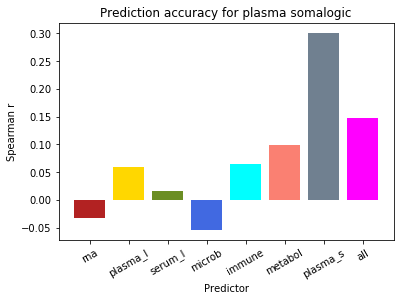

In [97]:
#Plot the results
f = plt.figure()
plt.bar(y_pos, each_omic_test, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 
                                       'cyan', 'salmon', 'slategray', 'magenta'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma somalogic')
plt.xticks(rotation=30)
#plt.show()

#os.chdir(Desktop)
f.savefig("CNNM_bars_plasmaS_test.pdf", bbox_inches='tight')

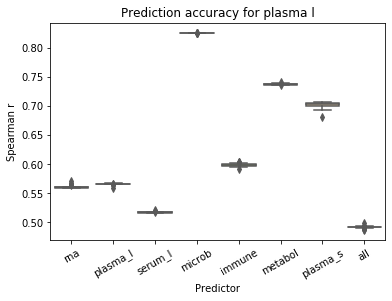

In [92]:
#Boxplots
import seaborn as sns
bxp = sns.boxplot(x=predictors, y=runs_train, palette="Set2")
bxp.set_xticklabels(bxp.get_xticklabels(),rotation=30)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
#plt.show()
fig = bxp.get_figure()
fig.savefig("CNNM_boxesRuns_plasma_train.pdf")

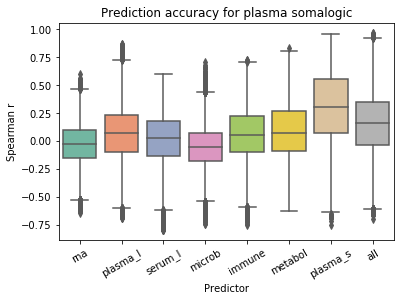

In [96]:
#Boxplots
bxp = sns.boxplot(x=predictors, y=features_test, palette="Set2")
bxp.set_xticklabels(bxp.get_xticklabels(),rotation=30)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma somalogic')
#plt.show()
fig = bxp.get_figure()
fig.savefig("CNNM_boxesFeat_plasma_s_test.pdf")

In [ ]:
X = []
for chapter in range(len(picture_book)):
    X.append(np.asarray(picture_book[chapter][pred])) 

X = np.vstack(X)

In [27]:
X.shape

(1972, 40, 40)

In [26]:
X_m = [albums[0], albums[1], albums[2], albums[3], albums[4], albums[5], albums[6]]
del X_m[response_number]
X_m = np.array(X_m, dtype = float)

NameError: name 'albums' is not defined

In [ ]:
#Using all omics at once
prediction_train_m, observed_train_m, prediction_test_m, observed_test_m = zip(*Parallel(n_jobs=3)(delayed(butterfly.Models.multi_CNN)
                        (X_m, y, groups, pixels, features, folds, epochs, optimiser, loss) 
                        for cv in tqdm(range(nruns))))




  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
each_feature_train_m = []
each_run_train_m = []

each_feature_test_m = []
each_run_test_m = []

for runs in range(nruns):
    correl_train_m = prediction_train_m[runs].corrwith(observed_train_m[runs], axis = 0, method = statistic) 
    each_feature_train_m.append(correl_train_m)
    each_run_train_m.append(np.mean(each_feature_train_m))

    correl_test_m = prediction_test_m[runs].corrwith(observed_test_m[runs], axis = 0, method = statistic) 
    each_feature_test_m.append(correl_test_m)
    each_run_test_m.append(np.mean(each_feature_test_m))
    
all_omics_train = np.mean(each_run_train_m)
all_omics_test = np.mean(each_run_test_m)

In [78]:
#Results - all omics at once
each_omic_train.append(all_omics_train)
each_omic_test.append(all_omics_test)
runs_train.append(each_run_train_m)
runs_test.append(each_run_test_m)
features_train.append(each_feature_train_m)
features_test.append(each_feature_test_m)

In [73]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s', 'all', 'multi']
y_pos = np.arange(len(predictors))

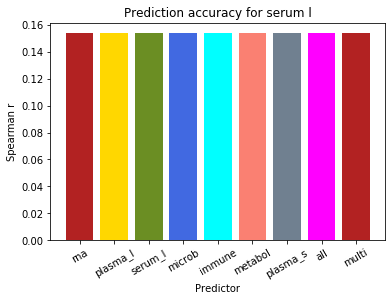

In [74]:
#Plot the results
f = plt.figure()
plt.bar(y_pos, each_omic_test, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 
                                       'cyan', 'salmon', 'slategray', 'magenta'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for serum l')
plt.xticks(rotation=30)
#plt.show()

#os.chdir(Desktop)
f.savefig("CNN_bars_serum_l_test.pdf", bbox_inches='tight')

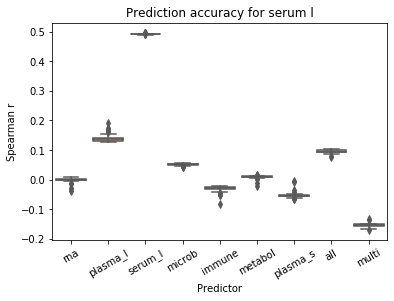

In [91]:
#Boxplots
import seaborn as sns
bxp = sns.boxplot(x=predictors, y=runs_test, palette="Set2")
bxp.set_xticklabels(bxp.get_xticklabels(),rotation=30)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for serum l')
#plt.show()
fig = bxp.get_figure()
fig.savefig("boxesRuns_serum_l_test.pdf")

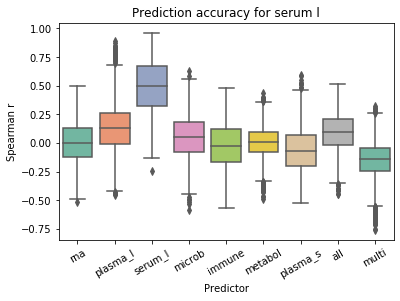

In [94]:
#Boxplots
bxp = sns.boxplot(x=predictors, y=features_test, palette="Set2")
bxp.set_xticklabels(bxp.get_xticklabels(),rotation=30)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for serum l')
#plt.show()
fig = bxp.get_figure()
fig.savefig("boxesFeat_serum_l_test.pdf")

In [12]:
print('test')

test
